In [1]:
import pyterrier as pt
import pandas as pd
from pyterrier.measures import RR, nDCG, MAP

In [2]:
dataset = pt.get_dataset("irds:beir/fiqa")

In [3]:
# Install the nlpaug package
# %pip install nlpaug

import nlpaug.augmenter.char as nac
# import nlpaug.augmenter.word as naw
# import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

# from nlpaug.util import Action

In [4]:
# Indexing documents
from pathlib import Path

indexer = pt.IterDictIndexer(
    str(Path.cwd()),  # this will be ignored
    type=pt.index.IndexingType.MEMORY,
    fields=["text"]
)
index_ref = indexer.index(dataset.get_corpus_iter())

Java started (triggered by TerrierIndexer.__init__) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
beir/fiqa documents: 100%|██████████| 57638/57638 [00:29<00:00, 1959.40it/s]


In [27]:
# Add noise to the queries
# Load the test dataset
testset = pt.get_dataset("irds:beir/fiqa/test")

# Retrieve test queries
test_queries = testset.get_topics()

# Add noise by deleting characters 10% of the time
aug = nac.RandomCharAug(action="delete", aug_char_p=0.1, spec_char="")

# Apply noise to queries
noisy_queries_list = []
for _, row in test_queries.iterrows():
    noisy_query = aug.augment(row['query'])

    if isinstance(noisy_query, list):
        noisy_query = " ".join(noisy_query)

    noisy_queries_list.append({'qid': row['qid'], 'query': noisy_query})

noisy_queries_df = pd.DataFrame(noisy_queries_list)
noisy_queries_df["qid"] = noisy_queries_df["qid"].astype(str)

print("Original Query:", test_queries.iloc[0]['query'])
print("Noisy Query:", noisy_queries_df.iloc[0]['query'])

bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")

# Run the experiment
pt.Experiment(
    [bm25],
    noisy_queries_df,
    testset.get_qrels(),
    eval_metrics=[RR @ 10, nDCG @ 10, MAP @ 100],
)

Original Query: where should i park my rainy day emergency fund
Noisy Query: where should i park my ainy day mergency fud
09:51:39.680 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,name,RR@10,nDCG@10,AP@100
0,TerrierRetr(BM25),0.145615,0.120467,0.099014


In [28]:
# Define a Sequential Augmentation Pipeline (Substitution + Insert)
# Load the test dataset
testset = pt.get_dataset("irds:beir/fiqa/test")

# Retrieve test queries
test_queries = testset.get_topics()

aug = naf.Sequential([
    nac.RandomCharAug(action="substitute", aug_char_p=0.2, spec_char=""),  # Substitute 20% of characters
    nac.RandomCharAug(action="insert", aug_char_p=0.2, spec_char="")       # Insert characters in 20% of positions
])

# Apply noise to queries
noisy_queries_list = []
for _, row in test_queries.iterrows():
    noisy_query = aug.augment(row['query'])

    if isinstance(noisy_query, list):
        noisy_query = " ".join(noisy_query)

    noisy_queries_list.append({'qid': row['qid'], 'query': noisy_query})

noisy_queries_df = pd.DataFrame(noisy_queries_list)

noisy_queries_df["qid"] = noisy_queries_df["qid"].astype(str)

print("Original Query:", test_queries.iloc[0]['query'])
print("Noisy Query:", noisy_queries_df.iloc[0]['query'])

bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")

# Run the experiment
pt.Experiment(
    [bm25],
    noisy_queries_df,
    testset.get_qrels(),
    eval_metrics=[RR @ 10, nDCG @ 10, MAP @ 100],
)


Original Query: where should i park my rainy day emergency fund
Noisy Query: yhere should i Opark my raSny day eFer8gxnc9y pfund
09:51:54.767 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,name,RR@10,nDCG@10,AP@100
0,TerrierRetr(BM25),0.076055,0.066641,0.054936


In [13]:
testset = pt.get_dataset("irds:beir/fiqa/test")
test_queries = testset.get_topics()

# Define noise levels
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# Define different noise type proportions
noise_combinations = [
    {"sub": 1.0, "ins": 0.0, "del": 0.0},  # Only substitution
    {"sub": 0.0, "ins": 1.0, "del": 0.0},  # Only insertion
    {"sub": 0.0, "ins": 0.0, "del": 1.0},  # Only deletion
    {"sub": 0.5, "ins": 0.5, "del": 0.0},  # Substitution + Insertion
    {"sub": 0.5, "ins": 0.0, "del": 0.5},  # Substitution + Deletion
    {"sub": 0.0, "ins": 0.5, "del": 0.5},  # Insertion + Deletion
    {"sub": 0.33, "ins": 0.33, "del": 0.33},  # Equal mix
]

bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")
results = []

for noise_level in noise_levels:
    for noise_config in noise_combinations:
        # Set noise probabilities
        sub_prob = noise_level * noise_config["sub"]
        ins_prob = noise_level * noise_config["ins"]
        del_prob = noise_level * noise_config["del"]

        # print(f"Noise Level: {noise_level}")
        # print(f"Substitution Probability: {sub_prob}")
        # print(f"Insertion Probability: {ins_prob}")
        # print(f"Deletion Probability: {del_prob}")

        aug = naf.Sequential([
            nac.RandomCharAug(action="substitute", aug_char_p=0.25, aug_word_p=sub_prob, spec_char="", aug_char_min=0, aug_word_min=0, aug_char_max=500000, aug_word_max=500000),
            nac.RandomCharAug(action="insert", aug_char_p=0.25, aug_word_p=ins_prob, spec_char="", aug_char_min=0, aug_word_min=0, aug_char_max=500000, aug_word_max=500000),
            nac.RandomCharAug(action="delete", aug_char_p=0.25, aug_word_p=del_prob, aug_char_min=0, aug_word_min=0, aug_char_max=500000, aug_word_max=500000)
        ])

        # Apply noise to queries
        noisy_queries_list = []
        for _, row in test_queries.iterrows():
            noisy_query = aug.augment(row['query'])
            if isinstance(noisy_query, list):
                noisy_query = " ".join(noisy_query)
            noisy_queries_list.append({'qid': row['qid'], 'query': noisy_query})

        noisy_queries_df = pd.DataFrame(noisy_queries_list)
        noisy_queries_df["qid"] = noisy_queries_df["qid"].astype(str)

        # print("Original query:", test_queries.iloc[0]['query'])
        # print("Noisy query:", noisy_queries_df.iloc[0]['query'])

        # Run retrieval experiment
        eval_result = pt.Experiment(
            [bm25],
            noisy_queries_df,
            testset.get_qrels(),
            eval_metrics=[RR @ 10, nDCG @ 10, MAP @ 100]
        )

        # Store results
        eval_result["noise_level"] = noise_level
        eval_result["sub_prob"] = sub_prob
        eval_result["ins_prob"] = ins_prob
        eval_result["del_prob"] = del_prob
        results.append(eval_result)

# Combine results
final_results = pd.concat(results, ignore_index=True)
print(final_results)


20:16:10.291 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


beir/fiqa documents:   0%|          | 0/57638 [04:37<?, ?it/s]


                 name     RR@10   nDCG@10    AP@100  noise_level  sub_prob  \
0   TerrierRetr(BM25)  0.310271  0.252589  0.208640          0.0     0.000   
1   TerrierRetr(BM25)  0.310271  0.252589  0.208640          0.0     0.000   
2   TerrierRetr(BM25)  0.310271  0.252589  0.208640          0.0     0.000   
3   TerrierRetr(BM25)  0.310271  0.252589  0.208640          0.0     0.000   
4   TerrierRetr(BM25)  0.310271  0.252589  0.208640          0.0     0.000   
5   TerrierRetr(BM25)  0.310271  0.252589  0.208640          0.0     0.000   
6   TerrierRetr(BM25)  0.310271  0.252589  0.208640          0.0     0.000   
7   TerrierRetr(BM25)  0.242874  0.200563  0.160619          0.1     0.100   
8   TerrierRetr(BM25)  0.232410  0.191982  0.157652          0.1     0.000   
9   TerrierRetr(BM25)  0.241576  0.203086  0.162698          0.1     0.000   
10  TerrierRetr(BM25)  0.243741  0.198886  0.162648          0.1     0.050   
11  TerrierRetr(BM25)  0.223746  0.185496  0.150792          0.1

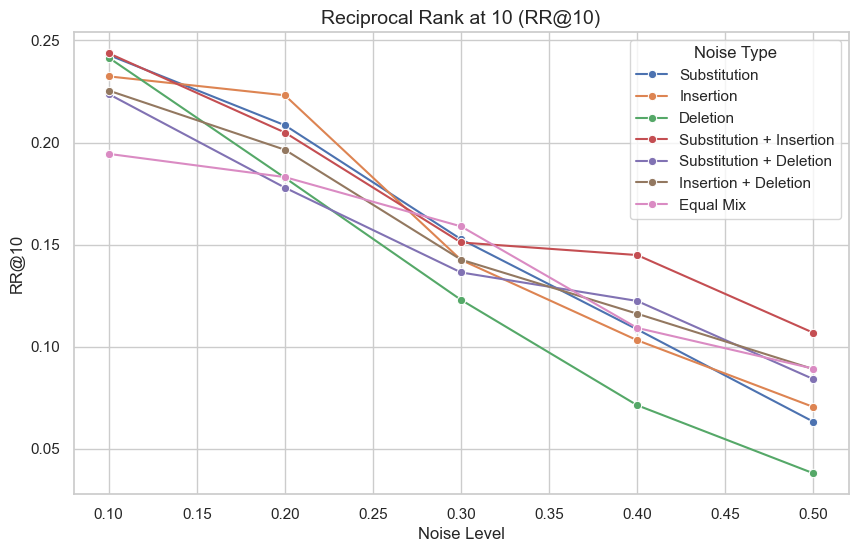

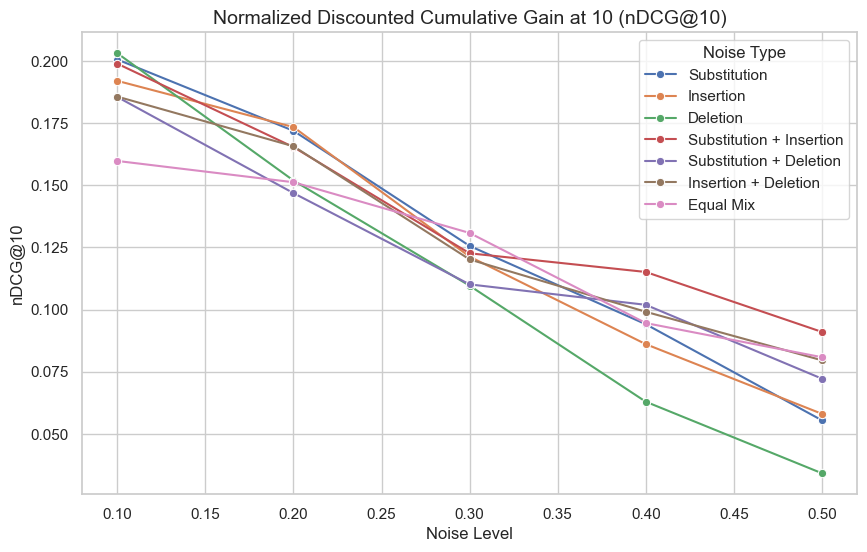

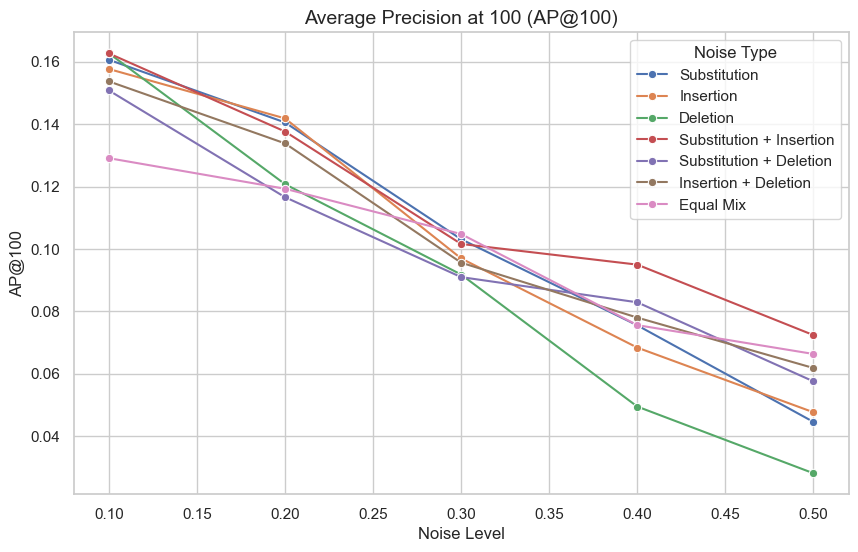

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_noise_label(row):
    if row["sub_prob"] > 0 and row["ins_prob"] == 0 and row["del_prob"] == 0:
        return "Substitution"
    elif row["sub_prob"] == 0 and row["ins_prob"] > 0 and row["del_prob"] == 0:
        return "Insertion"
    elif row["sub_prob"] == 0 and row["ins_prob"] == 0 and row["del_prob"] > 0:
        return "Deletion"
    elif row["sub_prob"] > 0 and row["ins_prob"] > 0 and row["del_prob"] == 0:
        return "Substitution + Insertion"
    elif row["sub_prob"] > 0 and row["ins_prob"] == 0 and row["del_prob"] > 0:
        return "Substitution + Deletion"
    elif row["sub_prob"] == 0 and row["ins_prob"] > 0 and row["del_prob"] > 0:
        return "Insertion + Deletion"
    elif row["sub_prob"] == row["ins_prob"] == row["del_prob"] and row["sub_prob"] != 0 and row["ins_prob"] != 0 and row["del_prob"] != 0:
        return "Equal Mix"

final_results["Noise Type"] = final_results.apply(get_noise_label, axis=1)

sns.set(style="whitegrid")

def plot_metric(metric, title):
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=final_results,
        x="noise_level",
        y=metric,
        hue="Noise Type",
        marker="o"
    )
    plt.title(title, fontsize=14)
    plt.xlabel("Noise Level", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.legend(title="Noise Type")
    plt.show()

plot_metric("RR@10", "Reciprocal Rank at 10 (RR@10)")
plot_metric("nDCG@10", "Normalized Discounted Cumulative Gain at 10 (nDCG@10)")
plot_metric("AP@100", "Average Precision at 100 (AP@100)")

In [8]:
# Calculate the number of words in queries
query_lengths = test_queries["query"].apply(lambda x: len(x.split()))

# Find the shortest and longest queries
shortest_query_length = query_lengths.min()
longest_query_length = query_lengths.max()

print(f"Shortest query length: {shortest_query_length}")
print(f"Longest query length: {longest_query_length}")


Shortest query length: 2
Longest query length: 31


In [9]:
import numpy as np

# Calculate word count per query
query_lengths = test_queries['query'].str.split().str.len()

# Compute percentiles
short_threshold = np.percentile(query_lengths, 25)  # 25th percentile
long_threshold = np.percentile(query_lengths, 75)  # 75th percentile

print(f"Short query threshold: {short_threshold} words")
print(f"Long query threshold: {long_threshold} words")

test_queries['query_length_category'] = test_queries['query'].apply(
    lambda q: "short" if len(q.split()) <= short_threshold else
              "long" if len(q.split()) > long_threshold else
              "medium"
)


Short query threshold: 8.0 words
Long query threshold: 14.0 words


In [11]:
import pandas as pd
import pyterrier as pt
import nlpaug.augmenter.char as nac
import nlpaug.flow as naf

# Define noise levels and types
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
noise_combinations = [
    {"sub": 1.0, "ins": 0.0, "del": 0.0},  # Only substitution
    {"sub": 0.0, "ins": 1.0, "del": 0.0},  # Only insertion
    {"sub": 0.0, "ins": 0.0, "del": 1.0},  # Only deletion
    {"sub": 0.5, "ins": 0.5, "del": 0.0},  # Substitution + Insertion
    {"sub": 0.5, "ins": 0.0, "del": 0.5},  # Substitution + Deletion
    {"sub": 0.0, "ins": 0.5, "del": 0.5},  # Insertion + Deletion
    {"sub": 0.33, "ins": 0.33, "del": 0.33},  # Equal mix
]

# Initialize BM25 retriever
bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")

# Group queries by length
query_groups = {
    "Short Queries": test_queries[test_queries["query_length_category"] == "short"],
    "Medium Queries": test_queries[test_queries["query_length_category"] == "medium"],
    "Long Queries": test_queries[test_queries["query_length_category"] == "long"]
}

results = []

for noise_level in noise_levels:
    for noise_config in noise_combinations:
        sub_prob = noise_level * noise_config["sub"]
        ins_prob = noise_level * noise_config["ins"]
        del_prob = noise_level * noise_config["del"]

        # Define noise augmentation
        aug = naf.Sequential([
            nac.RandomCharAug(action="substitute", aug_char_p=0.25, aug_word_p=sub_prob, spec_char=""),
            nac.RandomCharAug(action="insert", aug_char_p=0.25, aug_word_p=ins_prob, spec_char=""),
            nac.RandomCharAug(action="delete", aug_char_p=0.25, aug_word_p=del_prob, spec_char="")
        ])

        for group_name, queries in query_groups.items():
            # Apply noise to queries
            noisy_queries_list = []
            for _, row in queries.iterrows():
                noisy_query = aug.augment(row["query"])
                if isinstance(noisy_query, list):
                    noisy_query = " ".join(noisy_query)
                noisy_queries_list.append({"qid": row["qid"], "query": noisy_query})

            noisy_queries_df = pd.DataFrame(noisy_queries_list)
            noisy_queries_df["qid"] = noisy_queries_df["qid"].astype(str)

            # Run retrieval
            eval_result = pt.Experiment(
                [bm25],
                noisy_queries_df,
                testset.get_qrels(),
                eval_metrics=[RR @ 10, nDCG @ 10, MAP @ 100]
            )

            # Store results
            eval_result["noise_level"] = noise_level
            eval_result["sub_prob"] = sub_prob
            eval_result["ins_prob"] = ins_prob
            eval_result["del_prob"] = del_prob
            eval_result["query_group"] = group_name
            results.append(eval_result)

# Combine results
final_results = pd.concat(results, ignore_index=True)
print(final_results)


11:51:19.151 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
                  name     RR@10   nDCG@10    AP@100  noise_level  sub_prob  \
0    TerrierRetr(BM25)  0.120539  0.097817  0.082962          0.0     0.000   
1    TerrierRetr(BM25)  0.212920  0.169030  0.131487          0.0     0.000   
2    TerrierRetr(BM25)  0.230988  0.179536  0.146062          0.0     0.000   
3    TerrierRetr(BM25)  0.115034  0.102668  0.090026          0.0     0.000   
4    TerrierRetr(BM25)  0.198635  0.164626  0.132004          0.0     0.000   
..                 ...       ...       ...       ...          ...       ...   
121  TerrierRetr(BM25)  0.087751  0.069976  0.059409          0.5     0.000   
122  TerrierRetr(BM25)  0.093717  0.077336  0.059543          0.5     0.000   
123  T

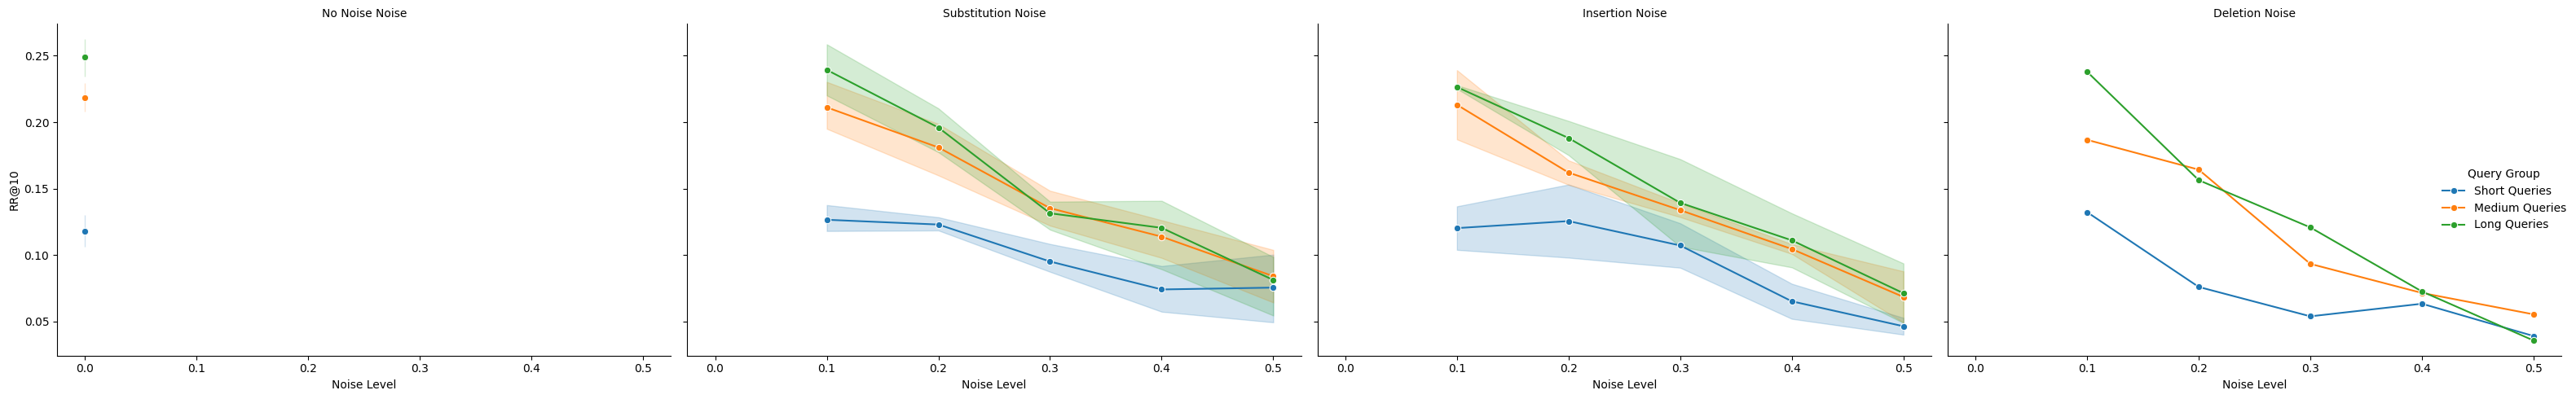

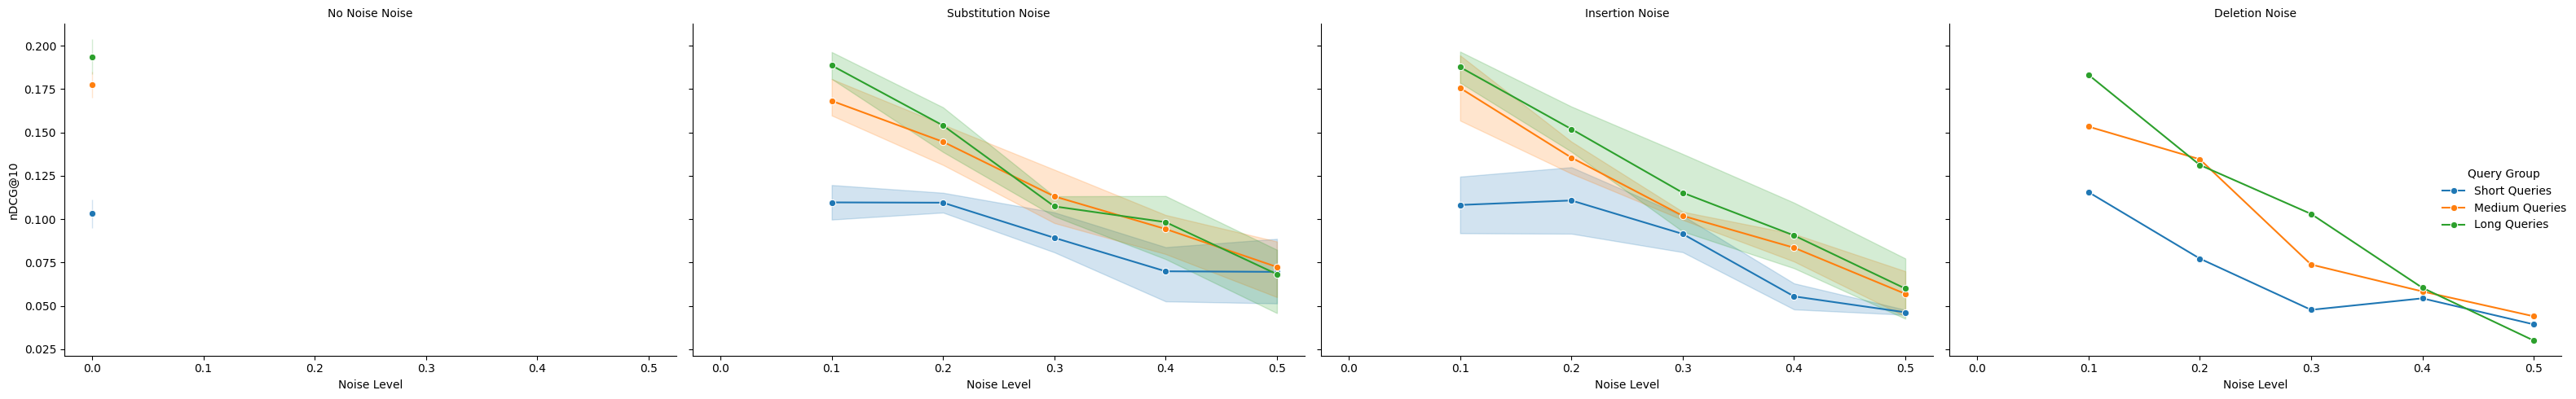

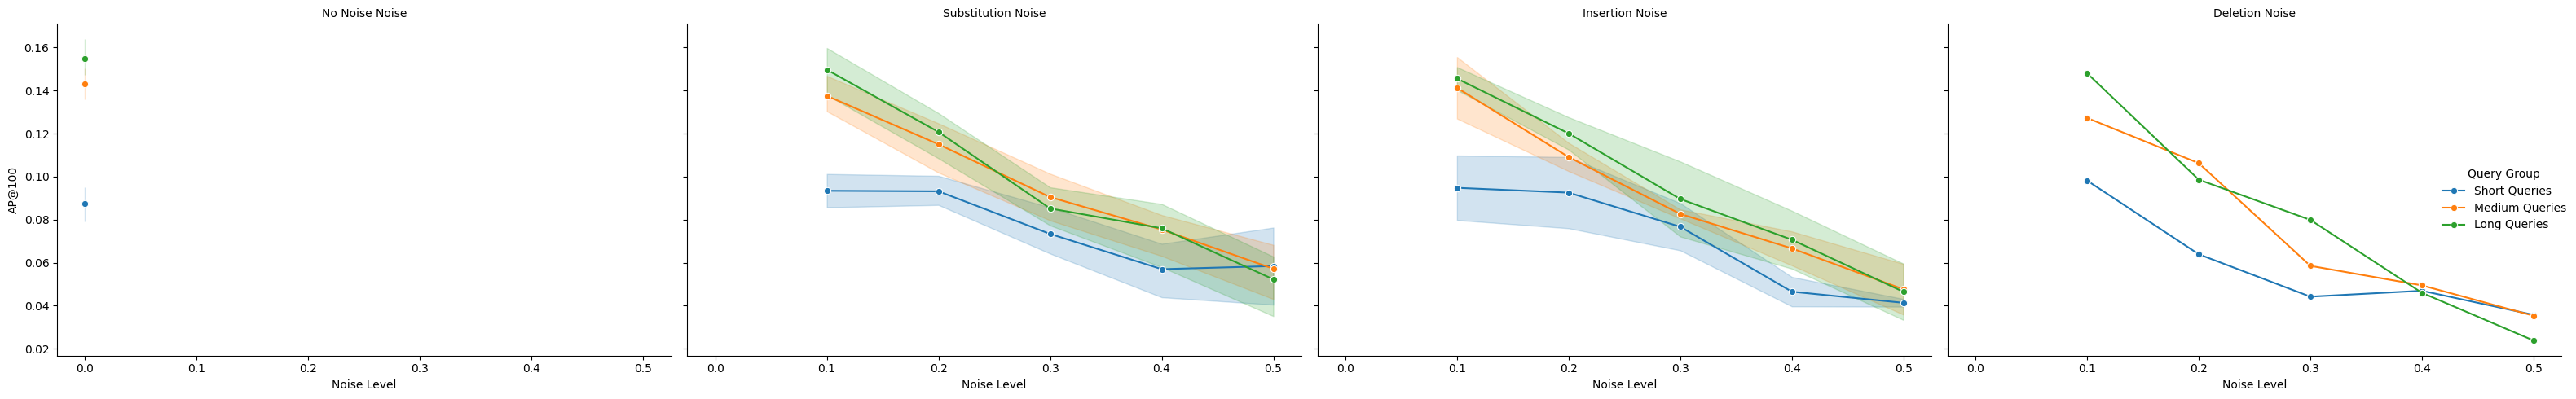

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the final results are in a DataFrame
final_results = pd.concat(results, ignore_index=True)

# Convert the result columns to proper types for plotting
final_results["noise_level"] = final_results["noise_level"].astype(float)
final_results["sub_prob"] = final_results["sub_prob"].astype(float)
final_results["ins_prob"] = final_results["ins_prob"].astype(float)
final_results["del_prob"] = final_results["del_prob"].astype(float)

# Create a new column to represent the noise type as a string
def get_noise_type(row):
    if row['sub_prob'] > 0:
        return 'Substitution'
    elif row['ins_prob'] > 0:
        return 'Insertion'
    elif row['del_prob'] > 0:
        return 'Deletion'
    else:
        return 'No Noise'

final_results['noise_type'] = final_results.apply(get_noise_type, axis=1)

# Plotting function for metrics with facet grid
def plot_metric(metric):
    # Create a FacetGrid for each noise type
    g = sns.FacetGrid(final_results, col="noise_type", hue="query_group", height=5, aspect=1.5)

    # Plot the results for each facet
    g.map(sns.lineplot, "noise_level", metric, marker="o")

    # Add titles, axis labels, and grid
    g.set_axis_labels('Noise Level', metric)
    g.set_titles(col_template="{col_name} Noise")
    g.add_legend(title='Query Group')

    plt.tight_layout()
    plt.show()

# Example plots for different metrics
plot_metric("RR@10")
plot_metric("nDCG@10")
plot_metric("AP@100")


In [11]:
testset = pt.get_dataset("irds:beir/fiqa/test")
test_queries = testset.get_topics()

# Define noise levels
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# Define different noise type proportions
noise_combinations = [
    {"sub": 1.0, "ins": 0.0, "del": 0.0},  # Only substitution
    {"sub": 0.0, "ins": 1.0, "del": 0.0},  # Only insertion
    {"sub": 0.0, "ins": 0.0, "del": 1.0},  # Only deletion
    {"sub": 0.5, "ins": 0.5, "del": 0.0},  # Substitution + Insertion
    {"sub": 0.5, "ins": 0.0, "del": 0.5},  # Substitution + Deletion
    {"sub": 0.0, "ins": 0.5, "del": 0.5},  # Insertion + Deletion
    {"sub": 0.33, "ins": 0.33, "del": 0.33},  # Equal mix
]

bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")
tfidf = pt.terrier.Retriever(index_ref, wmodel="TF_IDF")

# Run Experiment
retrievers = {
    "TF-IDF": tfidf,
    "BM25": bm25,
}


results = []

for noise_level in noise_levels:
    for noise_config in noise_combinations:
        sub_prob = noise_level * noise_config["sub"]
        ins_prob = noise_level * noise_config["ins"]
        del_prob = noise_level * noise_config["del"]

        aug = naf.Sequential([
            nac.RandomCharAug(action="substitute", aug_char_p=0.25, aug_word_p=sub_prob, spec_char=""),
            nac.RandomCharAug(action="insert", aug_char_p=0.25, aug_word_p=ins_prob, spec_char=""),
            nac.RandomCharAug(action="delete", aug_char_p=0.25, aug_word_p=del_prob, spec_char="")
        ])

        noisy_queries_list = []
        for _, row in test_queries.iterrows():
            noisy_query = aug.augment(row['query'])
            noisy_query = " ".join(noisy_query) if isinstance(noisy_query, list) else noisy_query
            noisy_queries_list.append({'qid': row['qid'], 'query': noisy_query})

        noisy_queries_df = pd.DataFrame(noisy_queries_list)
        noisy_queries_df["qid"] = noisy_queries_df["qid"].astype(str)

        for model_name, retriever in retrievers.items():
            eval_result = pt.Experiment(
                [retriever],
                noisy_queries_df,
                testset.get_qrels(),
                eval_metrics=[RR @ 10, nDCG @ 10, MAP @ 100]
            )

            eval_result["model"] = model_name
            eval_result["noise_level"] = noise_level
            eval_result["sub_prob"] = sub_prob
            eval_result["ins_prob"] = ins_prob
            eval_result["del_prob"] = del_prob
            results.append(eval_result)

# Combine results
final_results = pd.concat(results, ignore_index=True)
print(final_results)


18:40:53.981 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
18:41:13.266 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
                   name     RR@10   nDCG@10    AP@100   model  noise_level  \
0   TerrierRetr(TF_IDF)  0.193708  0.160207  0.131313  TF-IDF          0.0   
1     TerrierRetr(BM25)  0.189068  0.157252  0.129396    BM25          0.0   
2   TerrierRetr(TF_IDF)  0.191529  0.157459  0.125954  TF-IDF          0.0   
3     TerrierRetr(BM25)  0.189138  0.156573  0.124370    BM25          0.0   
4   TerrierRetr(TF_IDF)  0.193545  0.158545 

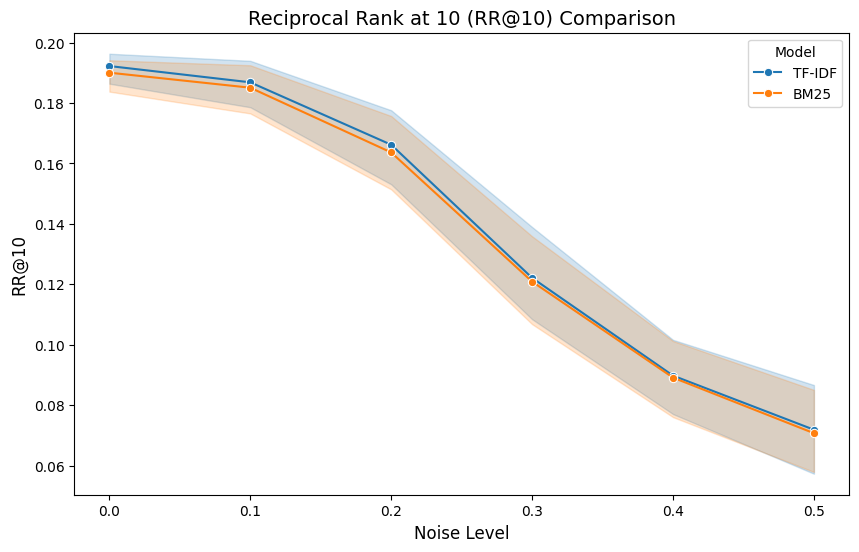

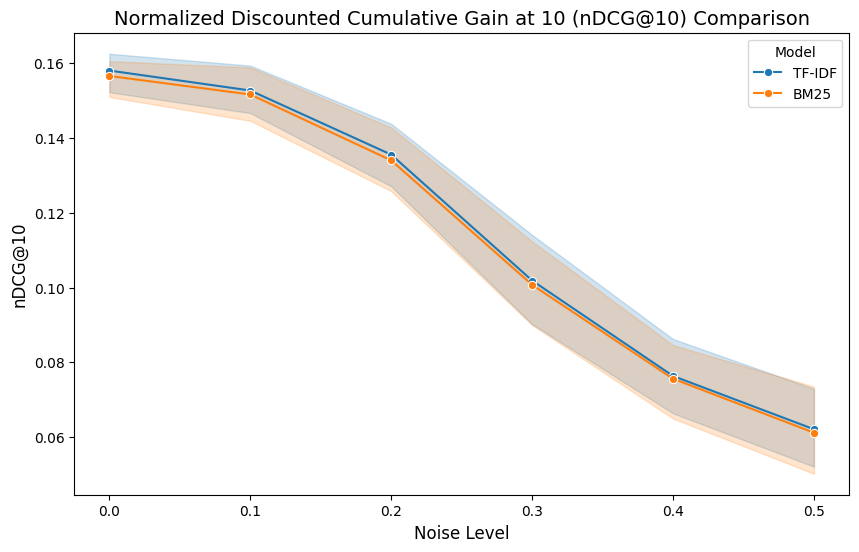

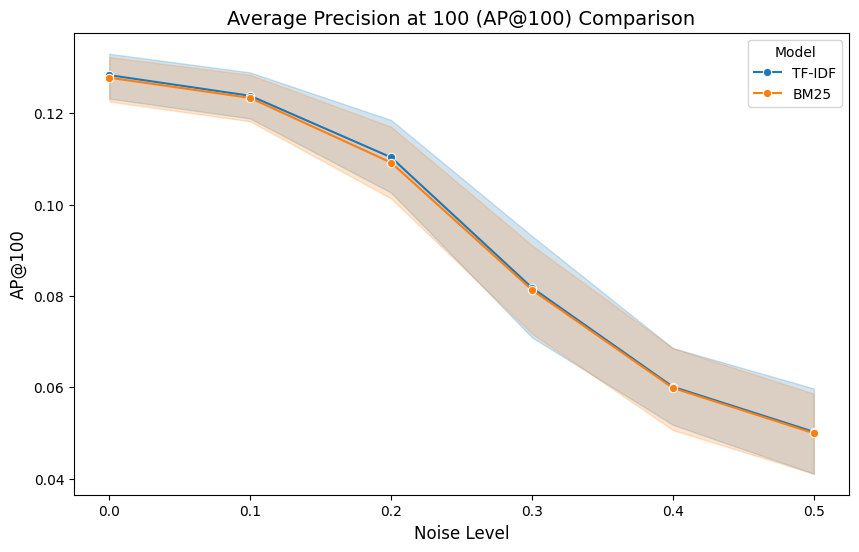

In [12]:
import seaborn as sns

import matplotlib.pyplot as plt

# Filter results for BM25 and TF-IDF
comparison_results = final_results[final_results["model"].isin(["BM25", "TF-IDF"])]

# Plotting function for metrics
def plot_comparison(metric, title):
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=comparison_results,
        x="noise_level",
        y=metric,
        hue="model",
        marker="o"
    )
    plt.title(title, fontsize=14)
    plt.xlabel("Noise Level", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.legend(title="Model")
    plt.show()

# Plot metrics
plot_comparison("RR@10", "Reciprocal Rank at 10 (RR@10) Comparison")
plot_comparison("nDCG@10", "Normalized Discounted Cumulative Gain at 10 (nDCG@10) Comparison")
plot_comparison("AP@100", "Average Precision at 100 (AP@100) Comparison")

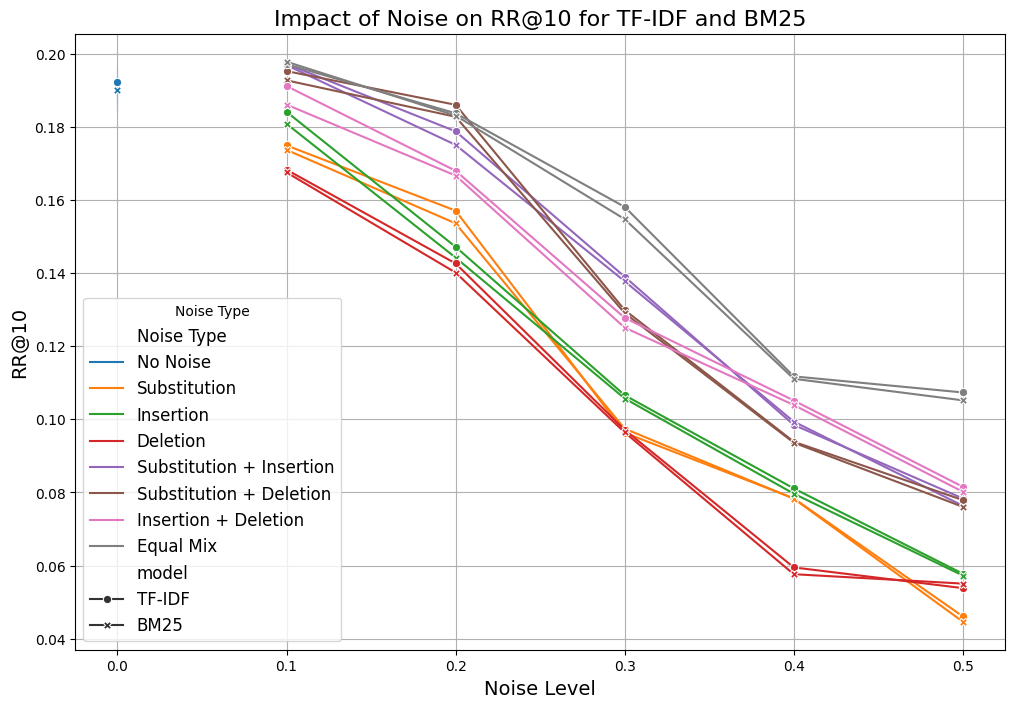

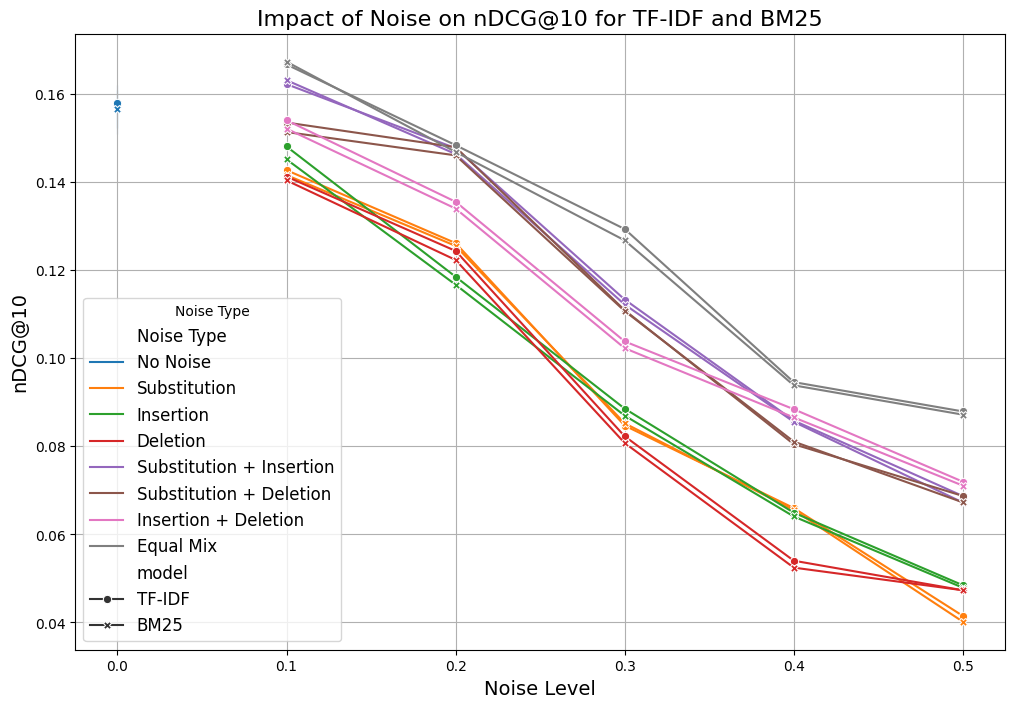

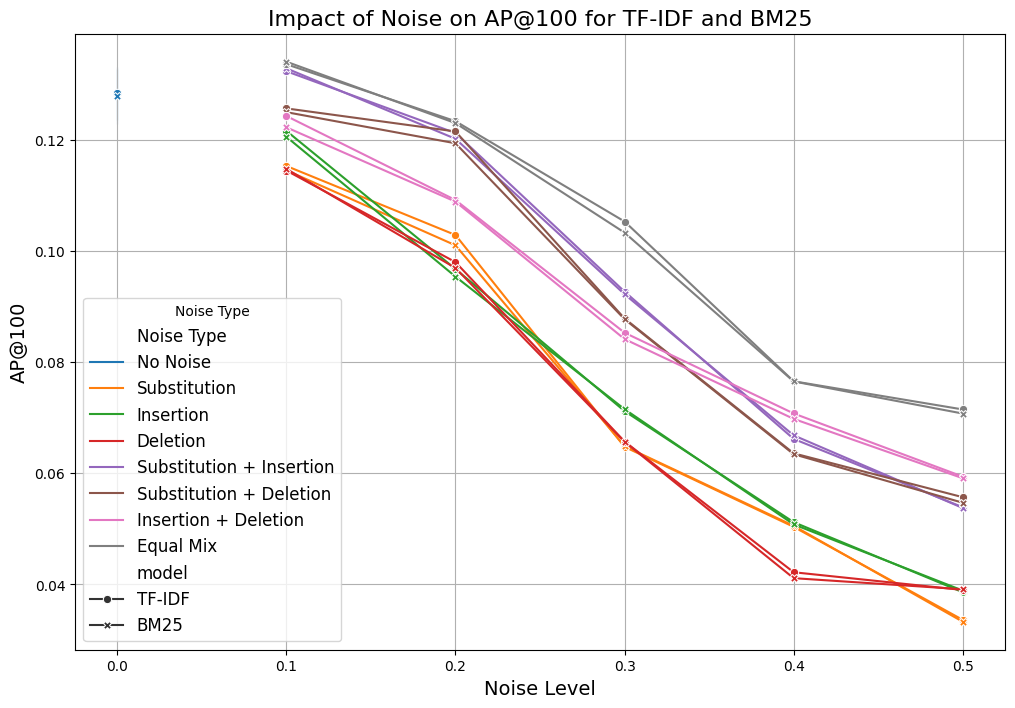

In [13]:
import seaborn as sns

import matplotlib.pyplot as plt

# Filter results for TF-IDF and BM25
comparison_results = final_results[final_results["model"].isin(["BM25", "TF-IDF"])]

# Create a new column to represent the noise type as a string
def get_noise_type(row):
    if row["sub_prob"] > 0 and row["ins_prob"] == 0 and row["del_prob"] == 0:
        return "Substitution"
    elif row["sub_prob"] == 0 and row["ins_prob"] > 0 and row["del_prob"] == 0:
        return "Insertion"
    elif row["sub_prob"] == 0 and row["ins_prob"] == 0 and row["del_prob"] > 0:
        return "Deletion"
    elif row["sub_prob"] > 0 and row["ins_prob"] > 0 and row["del_prob"] == 0:
        return "Substitution + Insertion"
    elif row["sub_prob"] > 0 and row["ins_prob"] == 0 and row["del_prob"] > 0:
        return "Substitution + Deletion"
    elif row["sub_prob"] == 0 and row["ins_prob"] > 0 and row["del_prob"] > 0:
        return "Insertion + Deletion"
    elif row["sub_prob"] == row["ins_prob"] == row["del_prob"] and row["sub_prob"] != 0:
        return "Equal Mix"
    else:
        return "No Noise"

comparison_results["Noise Type"] = comparison_results.apply(get_noise_type, axis=1)

# Plotting function for metrics
def plot_noise_impact(metric, title):
    plt.figure(figsize=(12, 8))
    sns.lineplot(
        data=comparison_results,
        x="noise_level",
        y=metric,
        hue="Noise Type",
        style="model",
        markers=True,
        dashes=False
    )
    plt.title(title, fontsize=16)
    plt.xlabel("Noise Level", fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.legend(title="Noise Type", fontsize=12)
    plt.grid(True)
    plt.show()

# Plot metrics
plot_noise_impact("RR@10", "Impact of Noise on RR@10 for TF-IDF and BM25")
plot_noise_impact("nDCG@10", "Impact of Noise on nDCG@10 for TF-IDF and BM25")
plot_noise_impact("AP@100", "Impact of Noise on AP@100 for TF-IDF and BM25")